# IUM-zespół 5 wariant 02
Marcin Jarczewski
Miłosz Mizak

## Zadanie
"Fajnie byłoby rozszerzyć nasz serwis o generowanie popularnych playlist – zestawów pasujących do siebie utworów, których słuchaniem zainteresowane będzie wiele osób"

### Definicja problemu biznesowego
Po dodatkowych ustaleniach z klientem zdecydowaliśmy, że będziemy generować kilka składek pogrupowanych względem gatunku muzycznego. Nasze zadanie ma na celu wygenerowanie składanek cieszących się zainteresowaniem wielu użytkowników. Do tej pory, składanki były generowane dynamicznie na podstawie dziesięciu najbardziej popularnych piosenek w serwisie w ciągu ostatnich 7 dni. Nasze rozwiązanie będzie opierało się na wybranych najpopularniejszych gatunkach muzycznych. Będziemy generować 5 składanek tygodniowo. Każda składanka będzie zawierała od 10 do 20 piosenek.

### Założenia
1. Skupimy się wyłącznie na najpopularniejszych gatunkach muzycznych, co będzie dodatkowo opisane w ramach analizy danych.
2. Do rozwiązania naszego problemu nie będzie nam potrzebna informacja dotycząca fizycznego przechowywania piosenek na dyskach.

### Zadania modelowania
Zadaniem modelowania będzie grupowanie (klasteryzacja) najpopularniejszych piosenek w składanki. Będzie się to odbywać dwuetapowo. Na początku, wybierzemy kilka najpopularniejszych piosenek w serwisie, a następnie dokonamy grupowania podobnych piosenek. Będziemy się skupiali na maksymalnie odległych grupach, aby utworzyć oddzielne playlisty. Jako dane wejściowe będziemy używali przetworzonych danych z pliku `sessions.jsonl`.
Dodatkowo możemy rozważyć zadanie rankingowania w ramach konkretnej grupy, tak żeby zmaksymalizować popularność konkretnej składanki.

Odrzucamy generowanie rekomendacji, ponieważ uśrednianie dla całego serwisu nie ma sensu i łamie twierdzenie "no free lunch", które mówi o nieistnieniu optymalnego rozwiązania dla każdego problemu.
Jako funkcji celu użyjemy znanej funkcji `triplet loss`. Wybieramy ją, ponieważ jest ona przydatna w zadaniach klasteryzacji, a poza tym posiadamy dane dzięki którym możemy przeprowadzić taką klasteryzację. Są to dane zawierające własności piosenek i znajdują się w pliku `tracks.jsonl`. 

Ilość danych jest według nas wystarczająca do rozwiązania zadania.

### Kryterium sukcesu
Będziemy porównywać składanki generowane przez dwa modele.
1. **Model podstawowy** — bierze najpopularniejsze piosenki danego gatunku i układa z nich składankę. Wybór piosenek opieramy na wskaźniku `popularity`.
2. **Model zaawansowany** — analizuje najczęściej słuchane piosenki danego gatunku, a następnie grupuje je z podobnymi do siebie i na tej podstawie układa składanki.

Porównywanie modeli będzie odbywać się w symulowanym środowisku, w którym będziemy dążyć do maksymalizacji czasu wysłuchania wszystkich piosenek z konkretnej składanki. W tym celu posłużymy się agentami, którzy będą symulować użytkowników. Chcemy osiągnąć większą retencję na składankach wygenerowanych przez model zaawansowany w porównaniu do modelu podstawowego. Retencja powinna wzrosnąć o $X\%$, gdzie $X >= 10$. Przez retencję określamy liczbę minut spędzonych na słuchaniu składanki w porównaniu do sumy długości wszystkich piosenek w danej składance. Dane na temat tego, jak długo była słuchana dana piosenka uzyskamy z danych o sesjach użytkowników. Dane wstęþne znajdują się w `sessions.jsonl`.

## Analiza danych

Zbiór danych zawiera następujące pliki:
- `artists.jsonl`: Opisuje pojedynczego artystę przy użyciu następujących atrybutów: id, nazwa oraz gatunki muzyczne.
- `tracks.jsonl`: Opisuje każdą piosenkę. Pojedyncza piosenka ma atrybuty opisujące jej: id, nazwę, wskaźnik popularności, czas trwania, id wykonawcy, datę wydania oraz różne wskaźniki pozwalające na porównywanie utworów.
- `sessions.jsonl`: Opisuje sesję użytkownika. Zawiera atrybuty id sesji, znacznik czasowy, id użytkownika, id piosenki, rodzaj wydarzenia.
- `users.jsonl`: Opisuje użytkownika. Posiada atrybuty: id, nazwa, adres zamieszkania, ulubione gatunki, wskaźnik czy jest użytkownikiem premium
- `track_storage.jsonl`: Opisuje miejsce przechowywania pojedynczego utworu. Atrybutami są: id piosenki, typ pamięci i dzienny koszt

Struktura danych i powiązań między sobą można zobaczyć na poniższym diagramie
![Obraz](./figures/db-diagram.png)

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

tracks_df = pd.read_json('./../data/raw/05_02_v2/tracks.jsonl', lines=True)
users_df = pd.read_json('./../data/raw/05_02_v2/users.jsonl', lines=True)
session_df = pd.read_json('./../data/raw/05_02_v2/sessions.jsonl', lines=True)
artists_df = pd.read_json('./../data/raw/05_02_v2/artists.jsonl', lines=True)
tracks_storage_df = pd.read_json('./../data/raw/05_02_v1/track_storage.jsonl', lines=True)

### `artists.jsonl`
Jak widać dane nie zawierają brakujących wartości.

In [4]:
artists_df.isnull().sum()

id        0
name      0
genres    0
dtype: int64

### `tracks.jsonl`

In [5]:
tracks_df.isnull().sum()

id                  0
name                0
popularity          0
duration_ms         0
explicit            0
id_artist           0
release_date        0
danceability        0
energy              0
key                 0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
dtype: int64

Jak widać tutaj również nie ma brakujących wartości. Najbardziej istotne dla nas są dane o gatunkach muzycznych konkretnych piosenek, połączone z danymi z pliku `artists.jsonl`. Jak widać 75% gatunków posiada średnio 77,5 piosenki. Zatem skupimy się tylko na gatunkach, które posiadają co najmniej 500 piosenek. Takich gatunków jest 37.


In [9]:
tracks_genre_df = tracks_df.merge(artists_df[['id', 'genres']], left_on='id_artist', right_on='id', how='inner')
exploded_genres = tracks_genre_df[['id_x', 'genres']].explode('genres').reset_index()
exploded_genres = exploded_genres.rename(columns={"id_x": "track_id", "genres": "genre"})
total_genre_counts = exploded_genres['genre'].value_counts().reset_index(name='count')
total_genre_counts.columns = ['genre', 'track count']
exploded_genres['genre'].value_counts().describe(), total_genre_counts[total_genre_counts['track count'] >= 500].shape

(count     779.000000
 mean      116.417202
 std       329.489929
 min         1.000000
 25%        12.000000
 50%        26.000000
 75%        77.500000
 max      4694.000000
 Name: count, dtype: float64,
 (37, 2))

<Axes: >

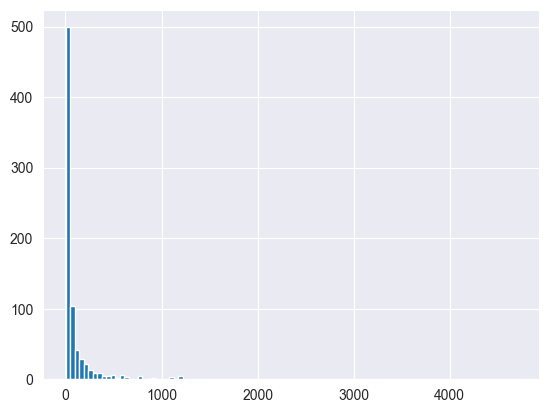

In [10]:
total_genre_counts['track count'].hist(bins=100)

<Axes: >

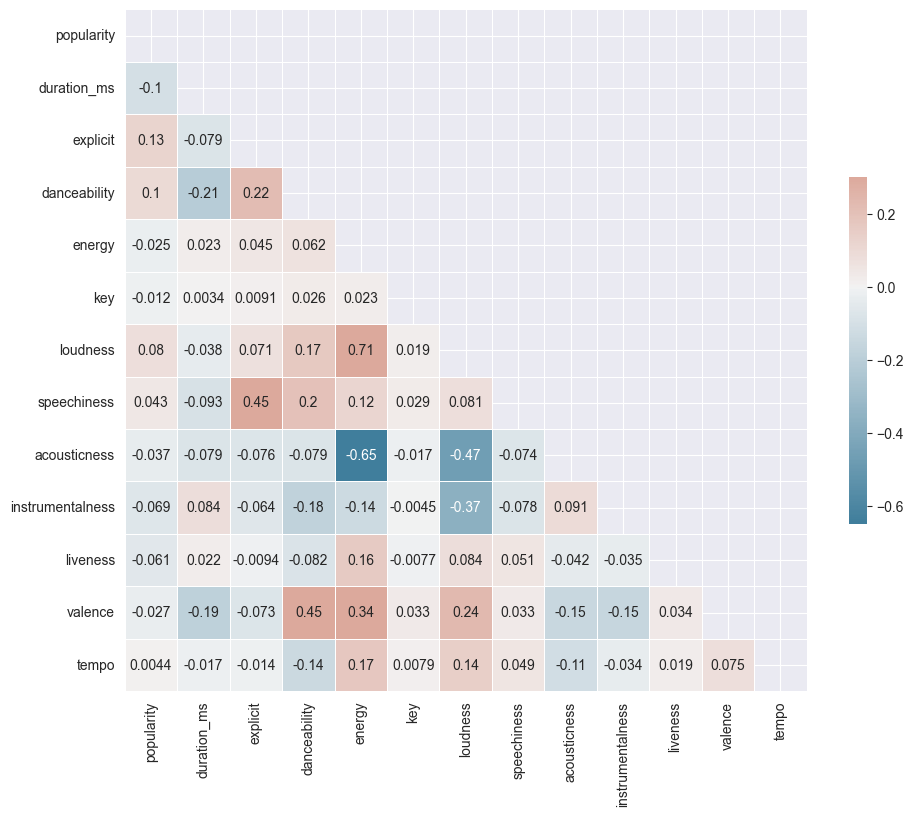

In [27]:
tracks_values = tracks_df.drop(columns=['id', 'name', 'id_artist', 'release_date'])
corr = tracks_values.corr()

f, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Wykres przedstawia korelację poszczególnych atrybutów piosenek.

### `sessions.jsonl`
Jak widać nasze dane zawierają 102 tysiące wierszy z brakującymi `track_id`. Widać, że brak `track_id` jest wyłącznie podczas reklam co nie wpływa na nasz problem.

In [11]:
session_df.isnull().sum()

session_id         0
timestamp          0
user_id            0
track_id      102466
event_type         0
dtype: int64

In [12]:
session_df[session_df['track_id'].isna()]['event_type'].unique()

array(['advertisment'], dtype=object)

Time range of the dataset: 2022-11-30 08:59:45 to 2023-11-30 09:06:15.969000


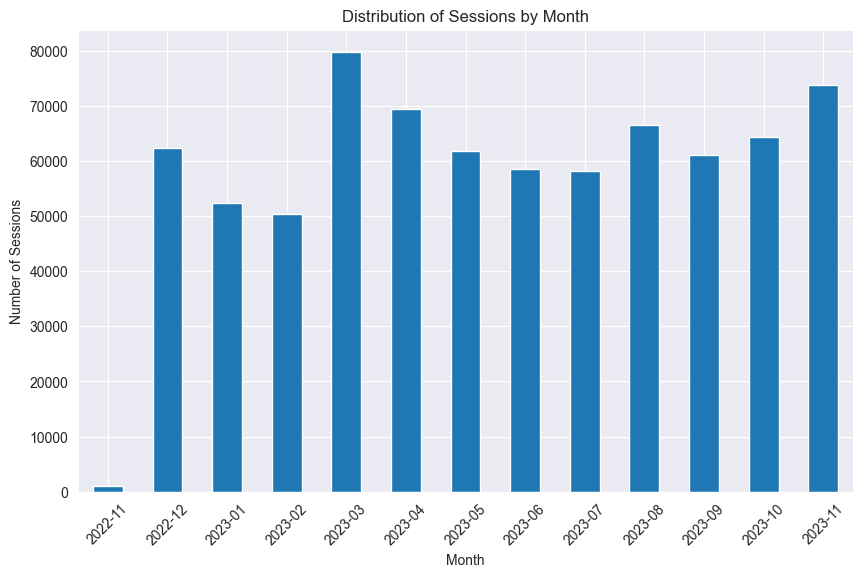

In [13]:
session_df['timestamp'] = pd.to_datetime(session_df['timestamp'])

start_date = session_df['timestamp'].min()
end_date = session_df['timestamp'].max()
print(f"Time range of the dataset: {start_date} to {end_date}")

session_df['year-month'] = session_df['timestamp'].dt.strftime('%Y-%m')
session_df['year-month'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6))

plt.title('Distribution of Sessions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.show()

Nasze dane są zbilansowane z wyłączeniem listopada 2022, gdzie posiadamy dane wyłącznie z 30 listopada.

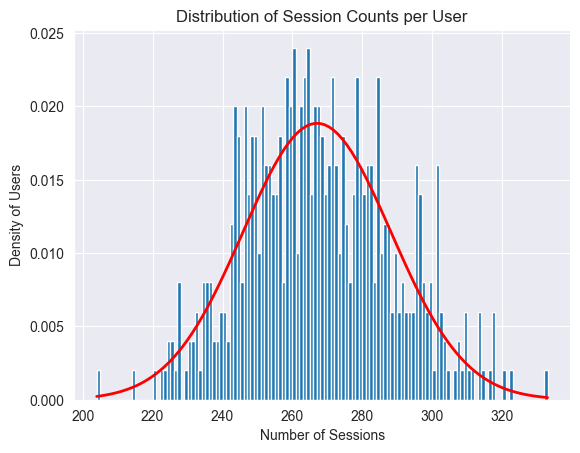

In [15]:
session_counts = session_df.groupby('user_id').session_id.nunique()

mean = session_counts.mean()
std = session_counts.std()

plt.hist(session_counts, bins=range(session_counts.min(), session_counts.max() + 1), edgecolor='white', density=True)
plt.title('Distribution of Session Counts per User')
plt.xlabel('Number of Sessions')
plt.ylabel('Density of Users')

x = np.linspace(session_counts.min(), session_counts.max(), 100)
y = stats.norm.pdf(x, mean, std)

plt.plot(x, y, 'r-', lw=2)
plt.show()

Histogram przedstawia znormalizowaną liczbę różnych sesji per użytkownik. Widać mało wartości odstających. Rozstrzał między maksymalną i minimalną liczbą sesji jest niski, więc są to dane zbalansowane. Wykres przypomina rozkład normalny, zatem traktujemy tę próbkę danych jako reprezentatywną.

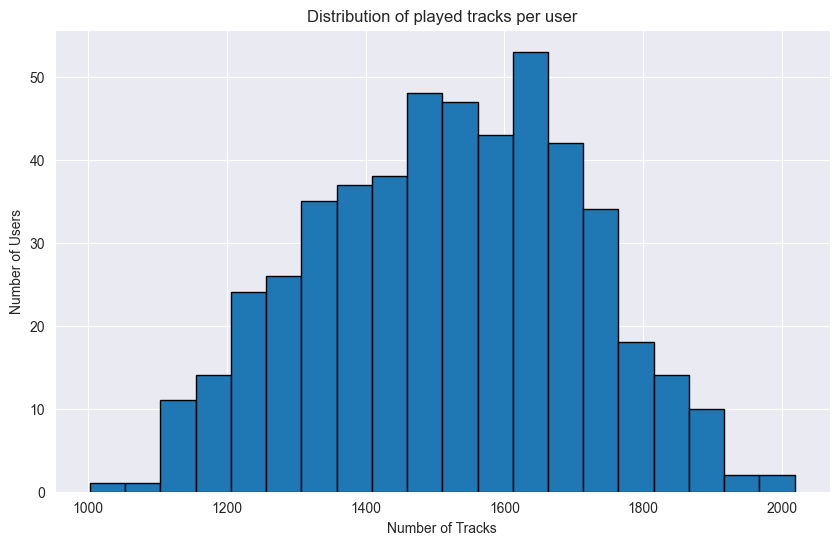

In [18]:
track_counts = session_df.groupby('user_id').size()

plt.figure(figsize=(10, 6))
plt.hist(track_counts, bins=20, edgecolor='black')
plt.title('Distribution of played tracks per user')
plt.xlabel('Number of Tracks')
plt.ylabel('Number of Users')
plt.show()

Wykres również przypomina rozkład normalny, podobnie jak w poprzednim punkcie, zatem te dane również traktujemy jako reprezentatywne.

In [20]:
events_per_session = session_df.groupby('session_id').size().mean()
print(f"Średnia liczba wydarzeń w 1 sesji: {events_per_session:.2f}")

Średnia liczba wydarzeń w 1 sesji: 5.69


### `users.jsonl`
Dane są kompletne i zawierają 500 użytkowników co potencjalnie może być później problemem, ze względu na ich niewielką liczbę.

In [22]:
users_df.isnull().sum()

user_id             0
name                0
city                0
street              0
favourite_genres    0
premium_user        0
dtype: int64

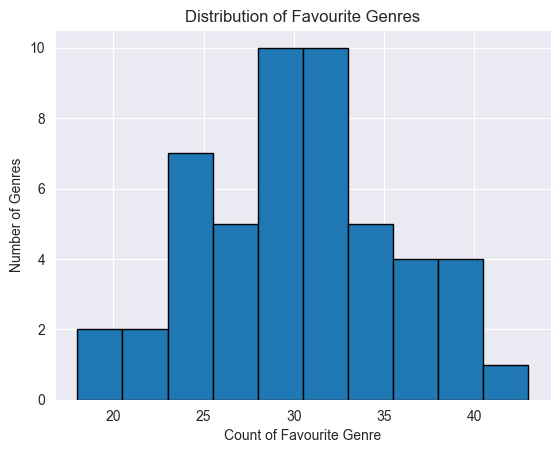

In [25]:
favourite_genres_series = users_df.explode('favourite_genres').groupby('favourite_genres').size().sort_values(ascending=False)
favourite_genres_df = favourite_genres_series.reset_index(name='count')
favourite_genres_df.columns = ['favourite_genres', 'count']

favourite_genres_df['count'].hist(bins=10, edgecolor='black')
plt.title('Distribution of Favourite Genres')
plt.xlabel('Count of Favourite Genre')
plt.ylabel('Number of Genres')
plt.show()

Wykres przedstawia liczbę ulubionych gatunków per użytkownik.

In [28]:
print(users_df.groupby('premium_user').size())

premium_user
False    388
True     112
dtype: int64


Większość użytkowników nie posiada konta premium, co sprawia, że może mieć to wpływ na pomijanie piosenek i irytację w trakcie słuchania.

### `track_storage.jsonl`

In [21]:
tracks_storage_df.isnull().sum()

track_id         0
storage_class    0
daily_cost       0
dtype: int64

Nie ma tutaj, żadnych brakujących wartości. Na podstawy naszego zadania te dane nie będą nam przydatne.

### `Statystyki par track-user`

In [33]:
def agg_events(x):
    return tuple(x)

tracks_tmp = tracks_df[['id', 'duration_ms']]
session_tmp = session_df.sort_values(by=['session_id', 'timestamp'], ascending=[True, True])

session_tmp['time_played'] = pd.to_datetime(session_tmp['timestamp']).diff().dt.total_seconds() * 1000
session_tmp['time_played'] = session_tmp['time_played'].shift(-1)

track_minutes_played = session_tmp.groupby(['track_id', 'user_id'])['time_played'].agg('sum').reset_index()
grouped_events = session_tmp.groupby(['track_id', 'user_id'])['event_type'].agg([agg_events]).reset_index()

track_user_stats = pd.merge(track_minutes_played, tracks_tmp, how='left', left_on='track_id', right_on='id')
track_user_stats = pd.merge(track_user_stats, grouped_events, how='left', on=['track_id', 'user_id'])

track_user_stats['percentage_played'] = track_user_stats['time_played'] / track_user_stats['duration_ms'] * 100
track_user_stats['percentage_played'] = track_user_stats.apply(lambda row: 100.0 if row.percentage_played > 100 else row.percentage_played, axis=1)
track_user_stats['was_liked'] = track_user_stats.apply(lambda row: 'like' in row.agg_events, axis=1)
track_user_stats['was_skipped'] = track_user_stats.apply(lambda row: 'skip' in row.agg_events, axis=1)

track_user_stats = track_user_stats.drop(columns=['id', 'agg_events'])
track_user_stats = track_user_stats.drop(track_user_stats[abs(track_user_stats.time_played) / 5 > track_user_stats.duration_ms].index)
track_user_stats = track_user_stats.drop(track_user_stats[track_user_stats.time_played == 0.0].index)

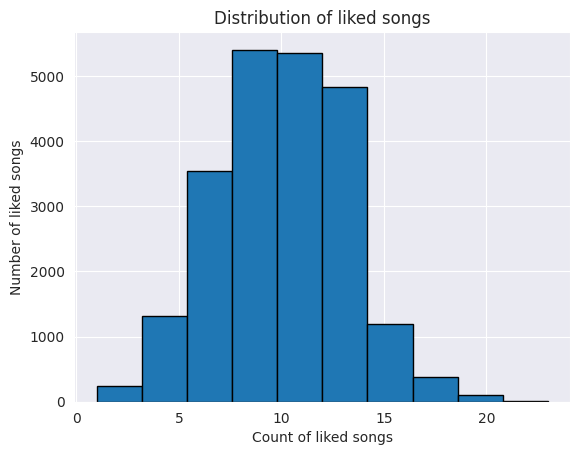

In [32]:
liked_tracks = track_user_stats
liked_tracks['times_liked'] = 0

liked_tracks = liked_tracks[liked_tracks['was_liked'] == False]
liked_tracks = liked_tracks.groupby(['track_id'])['times_liked'].agg('count').reset_index()

liked_tracks['times_liked'].hist(bins=10, edgecolor='black')
plt.title('Distribution of liked songs')
plt.xlabel('Count of liked songs')
plt.ylabel('Number of liked songs')
plt.show()

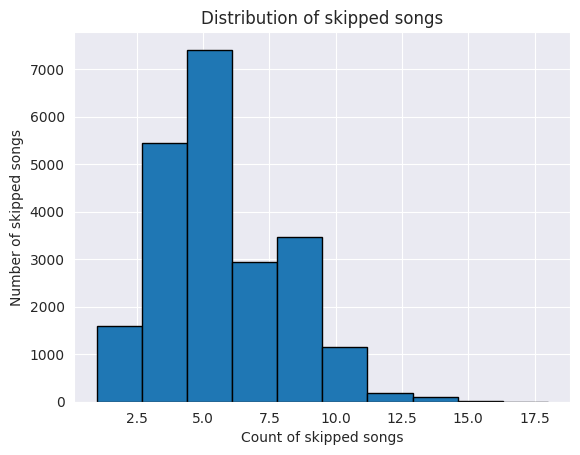

In [31]:
skipped_tracks = track_user_stats
skipped_tracks['times_skipped'] = 0

skipped_tracks = skipped_tracks[skipped_tracks['was_skipped'] == True]
skipped_tracks = skipped_tracks.groupby(['track_id'])['times_skipped'].agg('count').reset_index()

skipped_tracks['times_skipped'].hist(bins=10, edgecolor='black')
plt.title('Distribution of skipped songs')
plt.xlabel('Count of skipped songs')
plt.ylabel('Number of skipped songs')
plt.show()

Podczas analizy danych sesji użytkowników zauważyliśmy, że występują w nich błędy, np. ujemne wartości w kolumnie 'percentage_played'. Na tym etapie nie jesteśmy jeszcze w stanie stwierdzić, czy problemem jest niepoprawna obróbka danych czy jest to problem z samymi danymi.